In [10]:
from country import *
from disease import disease
from scipy import stats
import numpy as np

default = disease(2.3677029021650897*10**(-5),
 0.02465276930103708,
 0.052665118682770205,
 0.0001593990018386284)

In [3]:


env = GridEnvironemnt(0.005, 1)
population = [env.random_population() for _ in range(10)] 
#evolve(env : Environment, population, iterations)

population,curve,avg_curve,bests = evolve(env, population, 100)
population = sorted(population, key=lambda x : -env.fitness(x))

D:\_Monash 2024\Honours\FIT3191\assignment\country.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  time_to_event = lambda p: (-1/p)*np.log(np.random.random())


In [6]:
best = population[0]
print(env.fitness(best), best.get_params())

8584 (2.9245341942519186e-05, 0.010056964364167016, 0.07068171731690825, 0.00012477657603504976)


In [5]:
from matplotlib import pyplot

def get_infections(grid):
    n = len(grid) 
    m = len(grid[0])
    names = []
    infection_curves = []
    for i in range(n):
        for j in range(m):
            names.append((i,j))
            c = grid[i][j]
            infections = [I for S,I,R,D in c.history]
            inf_curve = [(t, s[1]) for t,s in zip(c.times, c.history)]
            infection_curves.append(inf_curve) 
    total_infections = add_curves(infection_curves)
    return total_infections

def plot_grid_curves(grid, max_population): 
    n = len(grid) 
    m = len(grid[0])
    names = []
    deaths = []
    infection_curves = []
    for i in range(n):
        for j in range(m):
            names.append((i,j))
            c = grid[i][j]
            infections = [I for S,I,R,D in c.history]
            inf_curve = [(t, s[1]) for t,s in zip(c.times, c.history)]
            infection_curves.append(inf_curve)
            deaths.append([(t, s[3]) for t,s in zip(c.times, c.history)])
            plt.plot(c.times, infections) 
    cumulative_deaths = add_curves(deaths)
    total_infections = add_curves(infection_curves)
    plt.plot(cumulative_deaths[0], cumulative_deaths[1])
    plt.plot(total_infections[0], total_infections[1])
    plt.xlabel("Days")
    plt.ylabel("Number of People")
    plt.legend(names+["Cumulative Deaths", "Total Infections"]) 
    plt.xlim(0, 365)
    plt.ylim(0, max_population)
    plt.show()

def get_peak(curve): 
    max = -math.inf 
    time = 0
    for t,v in curve: 
        if v > max:
            max = v 
            time = t
    return (time, max)

def get_peak_grid(grid): 
    n = len(grid)
    m = len(grid[0])
    peaks = []
    for i in range(n):
        for j in range(m):
            c = grid[i][j] 
            infections = [(t, s[1]) for t,s in zip(c.times, c.history)]
            peaks.append((i, j, get_peak(infections)))
    return peaks

In [12]:
countries,grid = create_grid(default, 0.0005, (3,3), True) 
grid[0][0].current[1] = 5
w = World(countries)
gillespie(w, 0,  t_max=365, max_iter=3*10**5)

more_infectious = default.copy()
more_infectious.l1 = 0.00004

countries,grid2 = create_grid(more_infectious, 0.0005, (3,3), True) 
grid2[0][0].current[1] = 5
w = World(countries)
gillespie(w, 0,  t_max=365, max_iter=3*10**5)

D:\_Monash 2024\Honours\FIT3191\assignment\country.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  time_to_event = lambda p: (-1/p)*np.log(np.random.random())


In [13]:
peaks = get_peak_grid(grid)
peaks2 = get_peak_grid(grid2)

Text(0, 0.5, 'Time of Peak (Days)')

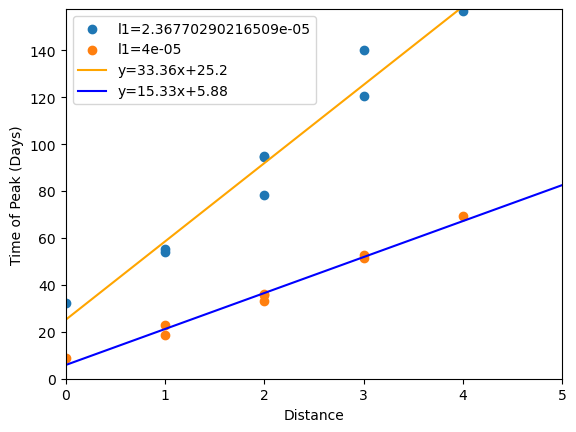

In [28]:
curve = [(i+j, peak[0]) for i,j,peak in peaks]
curve2 = [(i+j, peak[0]) for i,j,peak in peaks2]
x = [x for x,y in curve]
y = [y for x,y in curve]
x2 = [x for x,y in curve2]
y2 = [y for x,y in curve2]
slope, intercept, r, p, std_err = stats.linregress(x, y)
slope2, intercept2, r2, p2, std_err2 = stats.linregress(x2, y2)
plt.scatter(x,y)
plt.scatter(x2,y2)
plt.plot([0, max(x)+5], [intercept, slope*(max(x)+5)+intercept],
        color="orange")
plt.plot([0, max(x2)+5], [intercept2, slope2*(max(x2)+5)+intercept2],
        color="blue")
plt.legend([f"l1={default.l1}", f"l1={more_infectious.l1}",
           f"y={round(slope,2)}x+{round(intercept,2)}", 
            f"y={round(slope2, 2)}x+{round(intercept2,2)}"])
plt.ylim(0, max(y)+1)
plt.xlim(0, max(x)+1)
plt.xlabel("Distance")
plt.ylabel("Time of Peak (Days)")

In [26]:
print(slope, intercept, r**2)
print(slope2, intercept2, r2**2)

33.361764328161534 25.204635823350202 0.9616799153863616
15.328740280999487 5.880992938180448 0.9876597652426617


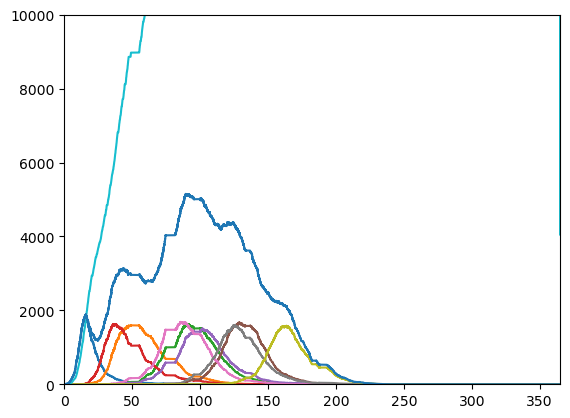

In [9]:
plot_grid_curves(grid,10000)

In [10]:
countries,grid = create_grid(best, 0.005, (2,2), True) 
grid[0][0].current[1] = 5
w = World(countries)
gillespie(w, 0,  t_max=365, max_iter=3*10**5)

In [11]:
infections = get_infections(grid)
print(infections[0][-1])

364.9997571185356


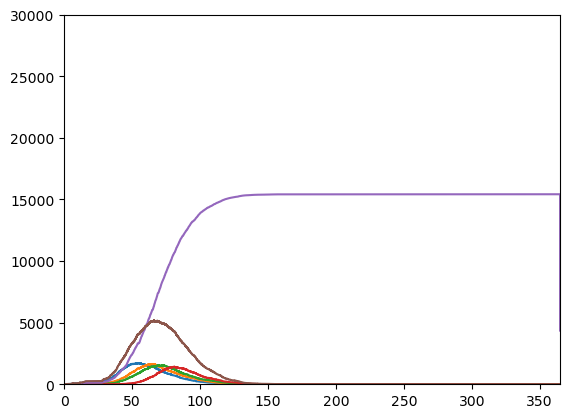

In [12]:
plot_grid_curves(grid, 30000)

In [13]:
best.get_params()

(2.453621568714017e-05,
 0.06162898481134512,
 0.05649803768927859,
 0.00012936356047484475)

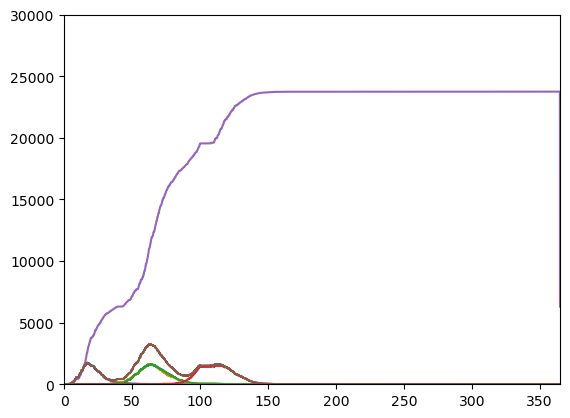

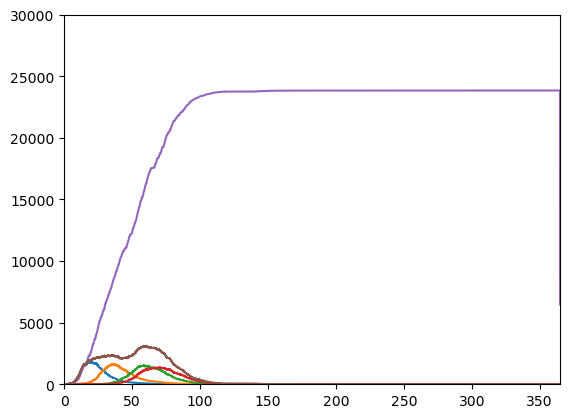

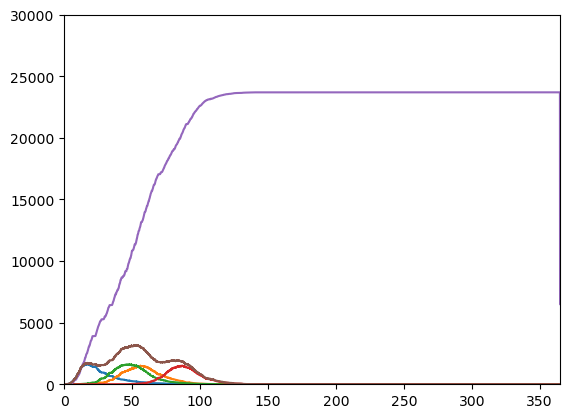

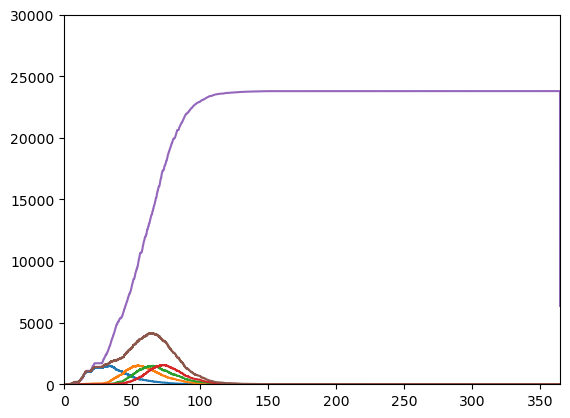

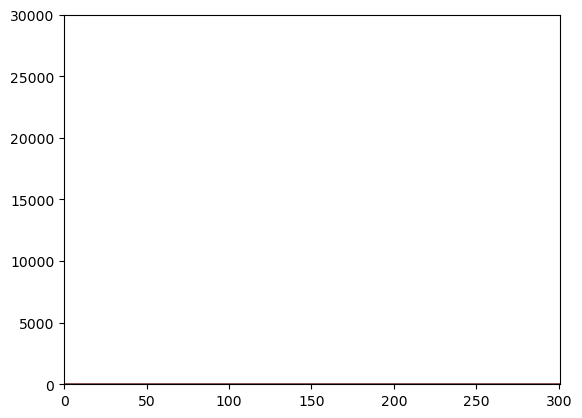

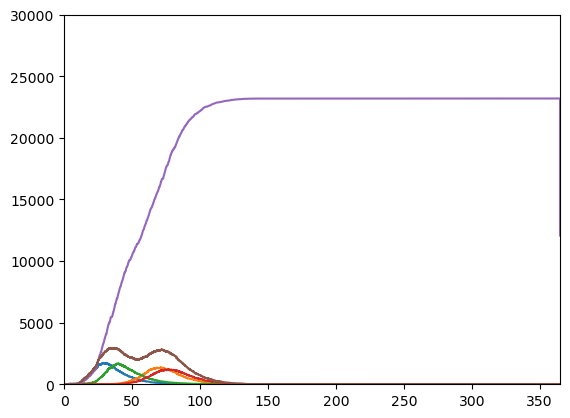

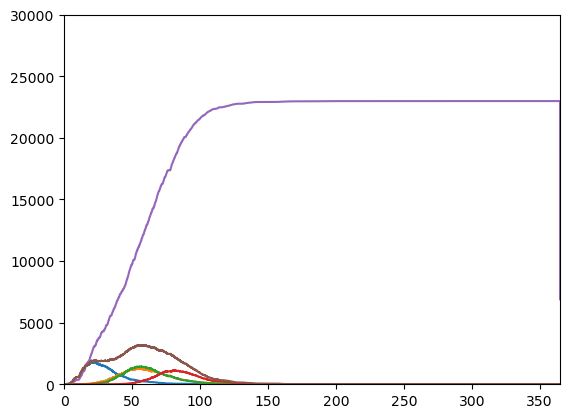

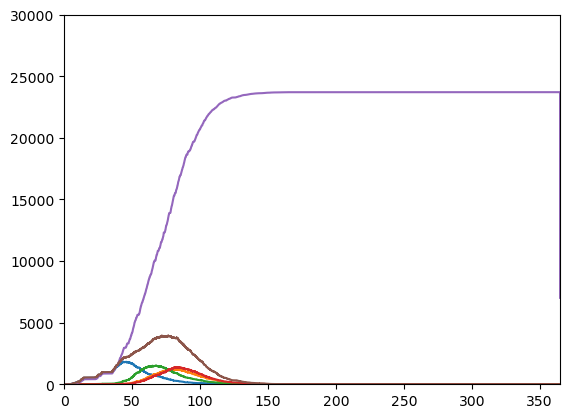

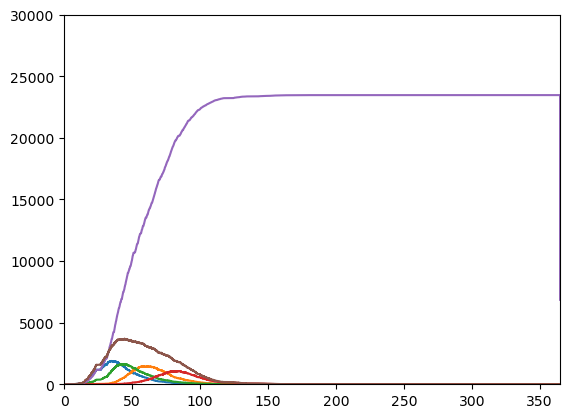

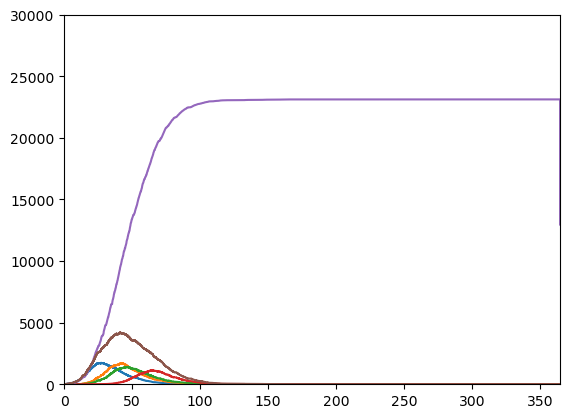

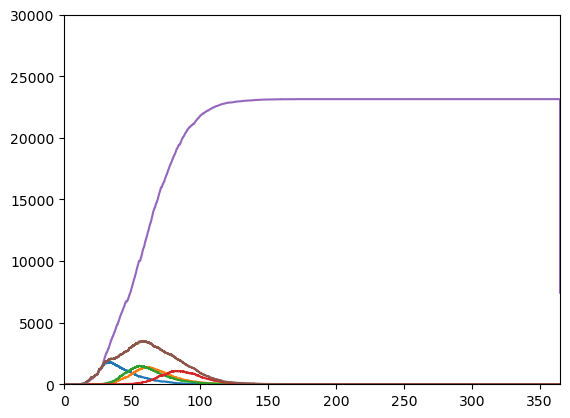

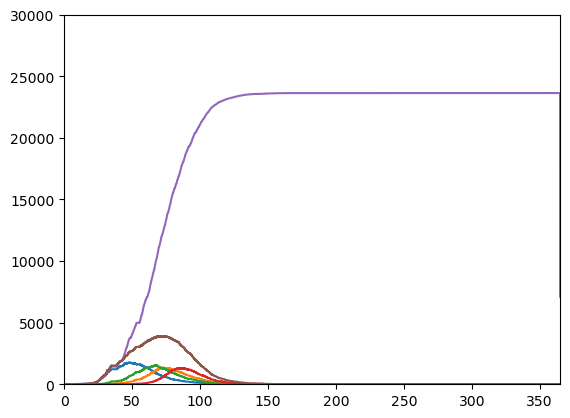

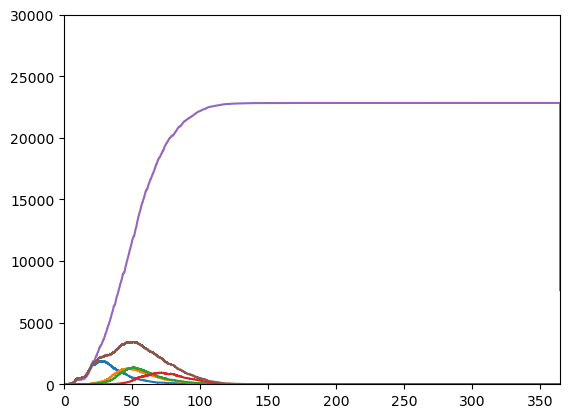

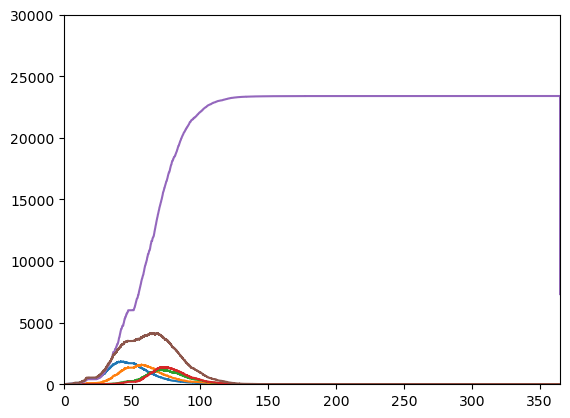

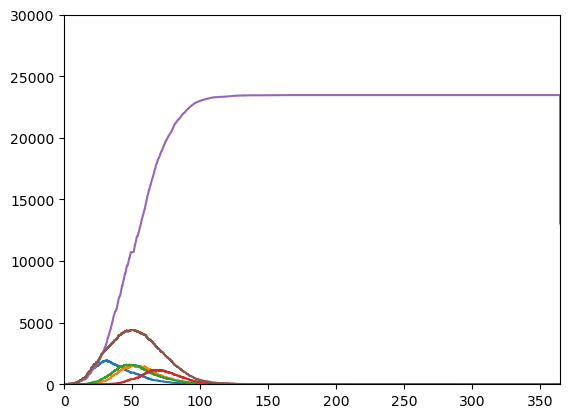

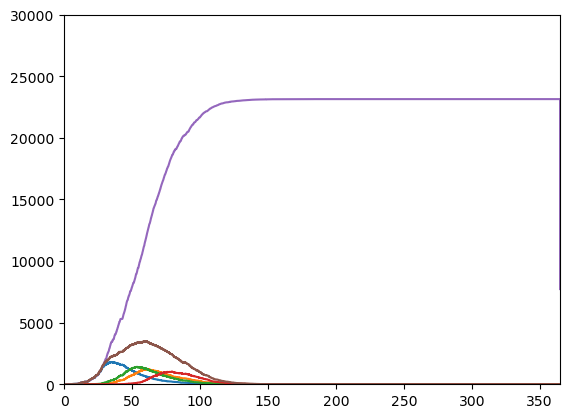

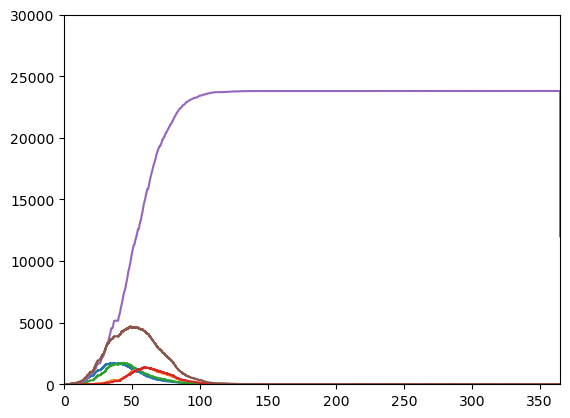

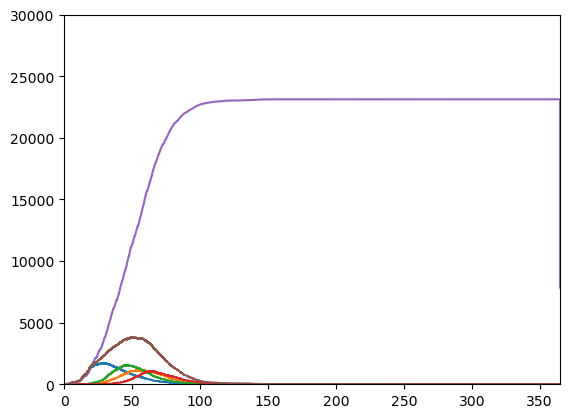

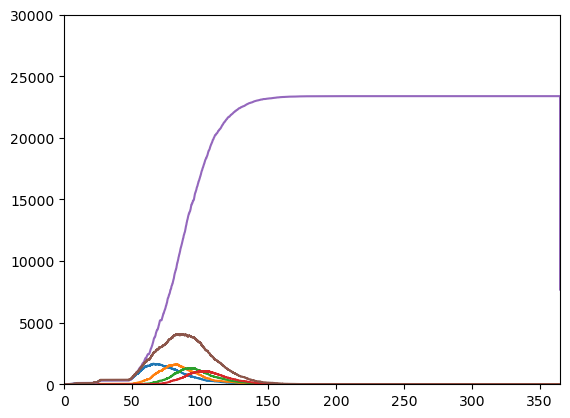

In [9]:
def find_end(grid): 
    infections = get_infections(grid)
    started = False
    for i,v in enumerate(infections[1]): 
        if not started and v >= 500:
            started = True
        if started and v < 10:
            return infections[0][i]
pandemic_length = []

for l in np.arange(0.0005, 0.01, 0.0005):
    countries,grid = create_grid(best, l, (2,2), True) 
    grid[0][0].current[1] = 5
    w = World(countries)
    gillespie(w, 0,  t_max=365, max_iter=3*10**5)
    plot_grid_curves(grid, 30000)
    pandemic_length.append(find_end(grid))
    

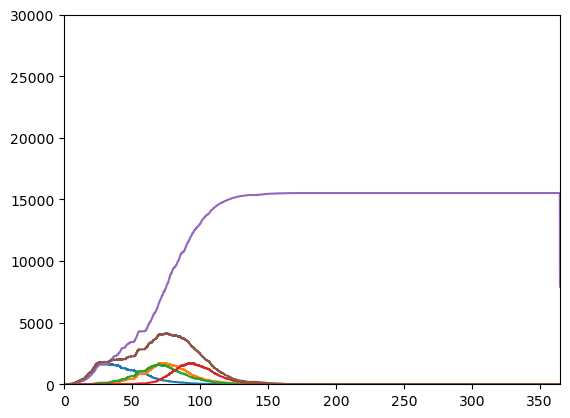

Text(0.5, 0, 'Movement between Countries')

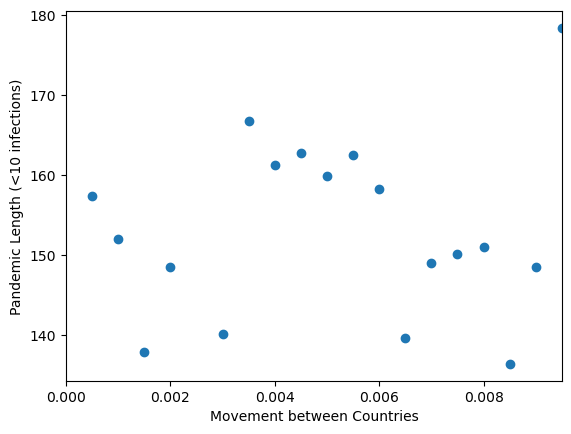

In [14]:
x=np.arange(0.0005, 0.01, 0.0005)
plt.scatter(x, pandemic_length)
plt.xlim(0, x[-1])
plt.ylabel("Pandemic Length (<10 infections)")
plt.xlabel("Movement between Countries")

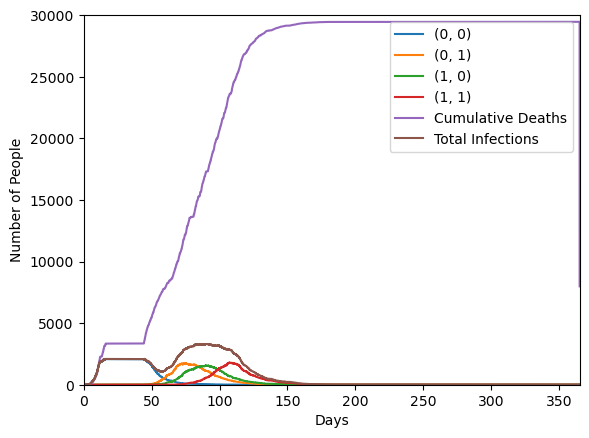

In [6]:
countries,grid = create_grid(best, 0.001, (2,2), True) 
grid[0][0].current[1] = 5
w = World(countries)
gillespie(w, 0,  t_max=365, max_iter=3*10**5)
plot_grid_curves(grid, 30000)

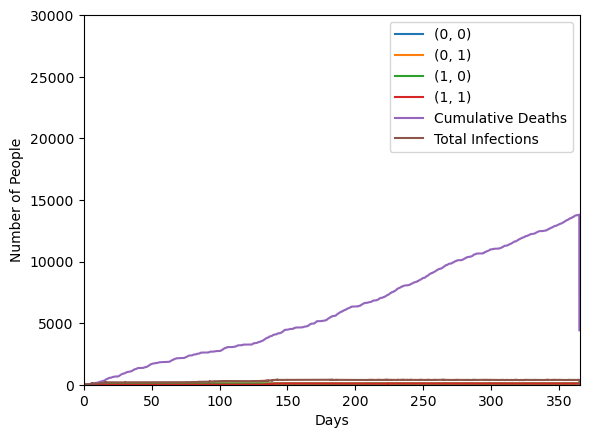

In [13]:
countries,grid = create_grid(best, 0.001, (2,2), True, lockdown=True, lockdown_threshold=0.001) 
grid[0][0].current[1] = 5
w = World(countries)
gillespie(w, 0,  t_max=365, max_iter=3*10**5)
plot_grid_curves(grid, 30000)

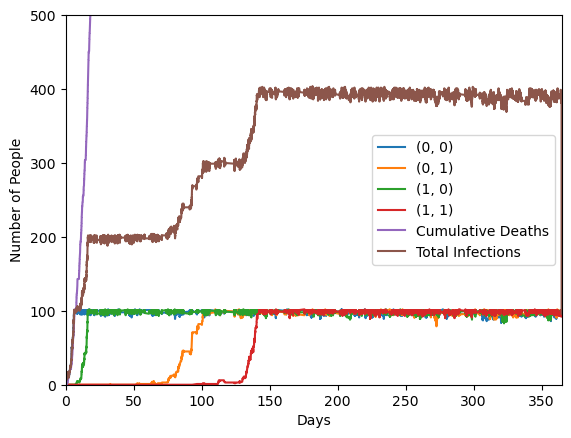

In [14]:
plot_grid_curves(grid, 500)

In [8]:
400/10000

0.04

In [15]:
diseases = []
for _ in range(10):
    env = GridEnvironemnt(0.005, 1)
    population = [env.random_population() for _ in range(10)] 
    #evolve(env : Environment, population, iterations)

    population,curve,avg_curve,bests = evolve(env, population, 100)
    population = sorted(population, key=lambda x : -env.fitness(x))
    diseases.append(population[0])

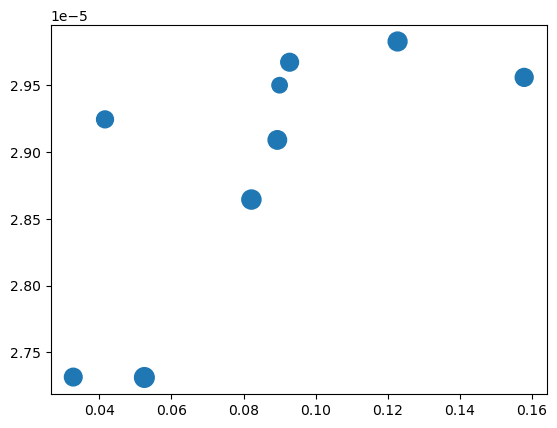

In [24]:
y = [d.l1 for d in diseases]
x = [d.l3 for d in diseases]
fitnesses = [env.fitness(d) for d in diseases]
max_fit = max(fitnesses)
min_fit = min(fitnesses)
diff = max_fit-min_fit
sizes =  [200*(env.fitness(d)-min_fit)/diff for d in diseases]
plt.scatter(x,y, sizes=sizes)

In [33]:
peaks = []
for _ in range(3):
    for l1 in np.arange(0.0001, 0.0004, 0.00005):
        more_infectious = default.copy()
        more_infectious.l1 = l1

        countries,grid2 = create_grid(more_infectious, 0.0005, (3,3), True) 
        grid2[0][0].current[1] = 5
        w = World(countries)
        gillespie(w, 0,  t_max=365, max_iter=3*10**5)
        peak = get_peak(get_infections(grid2))
        peaks.append((l1, get_peak_grid(grid2)))

ValueError: too many values to unpack (expected 2)

In [37]:
print(get_infections(grid2)[1][:5])

[0, 6, 6, 6, 6]
